In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 16.3MB/s 
     |████████████████████████████████| 3.3MB 53.7MB/s 
     |████████████████████████████████| 901kB 50.7MB/s 


In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

Mounted at /content/drive


In [ ]:
from transformers import BertTokenizer
import pandas as pd
import numpy as np # linear algebra
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time
#df = pd.read_csv('drive/My Drive/DL-Final-Project/Dataset/Subset2_Preprocessed_NoHashtag.csv',  lineterminator='\n')

In [ ]:
##tokenize dataset

training_data_file = 'drive/My Drive/DL-Final-Project/Dataset/FINAL_DATASET_NOHASHTAGS_2.csv'
vocabulary = 'drive/My Drive/DL-Final-Project/Dataset/bert-base-uncased-vocab.txt'  ##30522 tokens

L = open(training_data_file,'r').readlines()
training_set = [{'sentence': L[i].split(',')[0], 'label': int((L[i].split(',')[1][:-1]).replace('-1','0'))} for i in range(1,len(L)) if len(L[i].split(',')) >= 2]
tokenizer = BertTokenizer(vocabulary)

###example for LSTM
print(training_set[0])
print(tokenizer.encode(training_set[0]['sentence']))

{'sentence': 'rt lolpacorg why do we let the 1 control guns too please rt to show support for safe gun laws http t co qp', 'label': 1}
[101, 19387, 8840, 14277, 22684, 10623, 2339, 2079, 2057, 2292, 1996, 1015, 2491, 4409, 2205, 3531, 19387, 2000, 2265, 2490, 2005, 3647, 3282, 4277, 8299, 1056, 2522, 1053, 2361, 102]


In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
df = pd.DataFrame(training_set)
df.head()

,sentence,label
0,rt lolpacorg why do we let the 1 control guns ...,1
1,leeterryne fact background checks already stop...,1
2,rt jayandsteve hey a question nra are these pe...,1
3,franklautenberg guns kill 8 children daily i d...,1
4,nra wants 2 keep their guns 2 protect themselv...,1


In [ ]:
X,y = df['sentence'].values,df['label'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (12705,)
shape of test data is (4236,)


In [ ]:
for i in range(len(x_train)):
    x_train[i] = tokenizer.encode(x_train[i])

In [ ]:
for i in range(len(x_test)):
    x_test[i] = tokenizer.encode(x_test[i])

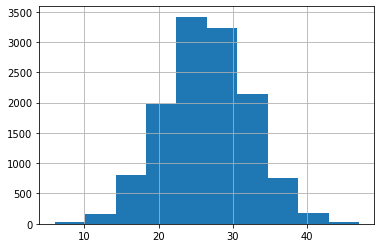

count    12705.000000
mean        26.510586
std          5.589063
min          6.000000
25%         23.000000
50%         26.000000
75%         30.000000
max         47.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
X,y = df['sentence'].values,df['label'].values
for i in range(len(X)):
    X[i] = tokenizer.encode(X[i])
X = torch.from_numpy(padding_(X,40))
y = torch.from_numpy(y)
print(X.shape)
print(y.shape)


torch.Size([16941, 40])
torch.Size([16941])


In [ ]:
# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#train_dataset = torch.load('/content/drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/train_tokenized.pt')
#val_dataset = torch.load('/content/drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/valid_tokenized.pt')
#test_dataset = torch.load('/content/drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/test_tokenized.pt')

from torch.utils.data import TensorDataset, random_split, RandomSampler, SequentialSampler

dataset = TensorDataset(X,y)
train_size = int(0.7*len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
useless_size = len(dataset) - train_size - val_size - test_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))


# train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
# valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            drop_last=True
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            drop_last=True
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            drop_last=True
        )


11,858 training samples
2,541 validation samples
2,542 test samples


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(LSTMModel,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers,batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.6)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim*40, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        # embeds = torch.tensor([self.embedding(s) for s in x])  # shape: B x S x Feature   since batch = True

        embeds = self.embedding(x)   # shape: B x S x Feature   since batch = True

        # print('embeds',embeds.shape)  #[8, 40, 64] seq_len x batch x feature_num
        
        lstm_out, hidden = self.lstm(embeds, hidden)
        # print('lstm_out',lstm_out.shape)
        # lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = lstm_out.contiguous().view(batch_size,-1) ##use all lstm outputs
        # out = lstm_out[:,-1,:].squeeze()
        # print('out',out.shape)
        
        # dropout and fully connected layer
        out = self.dropout(out)
        out = self.fc(out)
        
        # sigmoid function
        #sig_out = self.sig(out)
        # print('sig_out',sig_out.shape)
        # reshape to be batch_size first
        # sig_out = sig_out.view(batch_size, -1)

        #sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [ ]:
no_layers = 2
vocab_size = 30522 + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 2
hidden_dim = 256

model = LSTMModel(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.8)

In [ ]:
model.to(device)
print(model)

LSTMModel(
  (embedding): Embedding(30523, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=10240, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001


#weighting loss function to account for class imbalance
weight = torch.tensor([3589, 13352])
weight = weight / torch.sum(weight)
weight = 1 / weight
weight = weight / torch.sum(weight)
weight = weight.unsqueeze(0)
print(weight.shape)
print(weight)
criterion = nn.CrossEntropyLoss(weight = weight.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.argmax(pred.squeeze(), dim=1)
    return torch.sum(pred == label.squeeze()).item()

torch.Size([1, 2])
tensor([[0.7881, 0.2119]])


In [ ]:
clip = 5
epochs = 25 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    st = time.time()
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        # print('h',h[0].shape)

        # print("INPUTS",inputs.shape)
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        #loss = criterion(output.squeeze(), labels.float())
        loss = criterion(output,labels.long())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in validation_dataloader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels.long())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)
    epoch_val_acc = val_acc/len(validation_dataloader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print('lapse:',time.time()-st)
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
lapse: 8.86614465713501
train_loss : 0.406665787753409 val_loss : 0.3198723386068261
train_accuracy : 83.15904874346433 val_accuracy : 85.91105863833135
Validation loss decreased (inf --> 0.319872).  Saving model ...
Epoch 2
lapse: 8.512868642807007
train_loss : 0.2624120197599259 val_loss : 0.2989522781434589
train_accuracy : 89.31523022432113 val_accuracy : 86.89492325855961
Validation loss decreased (0.319872 --> 0.298952).  Saving model ...
Epoch 3
lapse: 8.51791000366211
train_loss : 0.16386741297558186 val_loss : 0.3932263790567373
train_accuracy : 93.69202226345084 val_accuracy : 90.5155450609996
Epoch 4
lapse: 8.656124353408813
train_loss : 0.08842734279106966 val_loss : 0.46411598781743935
train_accuracy : 96.71108112666555 val_accuracy : 88.66587957497049
Epoch 5
lapse: 8.573861598968506
train_loss : 0.046044129914225136 val_loss : 0.5997971451629193
train_accuracy : 98.44830494181144 val_accuracy : 87.13105076741441
Epoch 6
lapse: 8.709517002105713
train_loss : 0.029

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Record:


In [ ]:
from sklearn.metrics import classification_report

test_h = model.init_hidden(batch_size)
test_acc = 0.0
true_label = torch.tensor([])
pred_label = torch.tensor([])
model.eval()
with torch.no_grad():
  for steps, (inputs, labels) in enumerate(test_dataloader):
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)

    output, test_h = model(inputs, test_h)
    
    accuracy = acc(output,labels)
    test_acc += accuracy
    true_label = torch.cat((true_label,labels.cpu()),0)
    output = torch.argmax(output.squeeze(), dim=1)
    pred_label = torch.cat((pred_label,(output.cpu()).long()),0)
    # print(true_label)
    # print(pred_label)
    # if steps == 2: break

print(classification_report(true_label.numpy(),pred_label.numpy()))

              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77       560
         1.0       0.93      0.95      0.94      1976

    accuracy                           0.90      2536
   macro avg       0.86      0.85      0.86      2536
weighted avg       0.90      0.90      0.90      2536



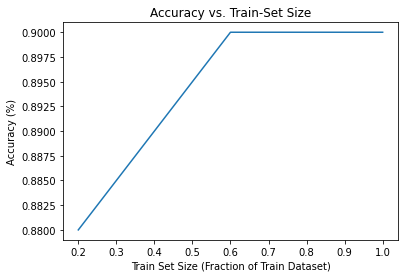

In [ ]:
accuracies = [.88, .89, .9, .9, .9]
train_sizes = [0.2, 0.4, 0.6, 0.8, 1]

plt.plot(train_sizes, accuracies)
plt.title("Accuracy vs. Train-Set Size")
plt.xlabel("Train Set Size (Fraction of Train Dataset)")
plt.ylabel("Accuracy (%)")
plt.show()